In [2]:
import zipfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

C:\Users\azras\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


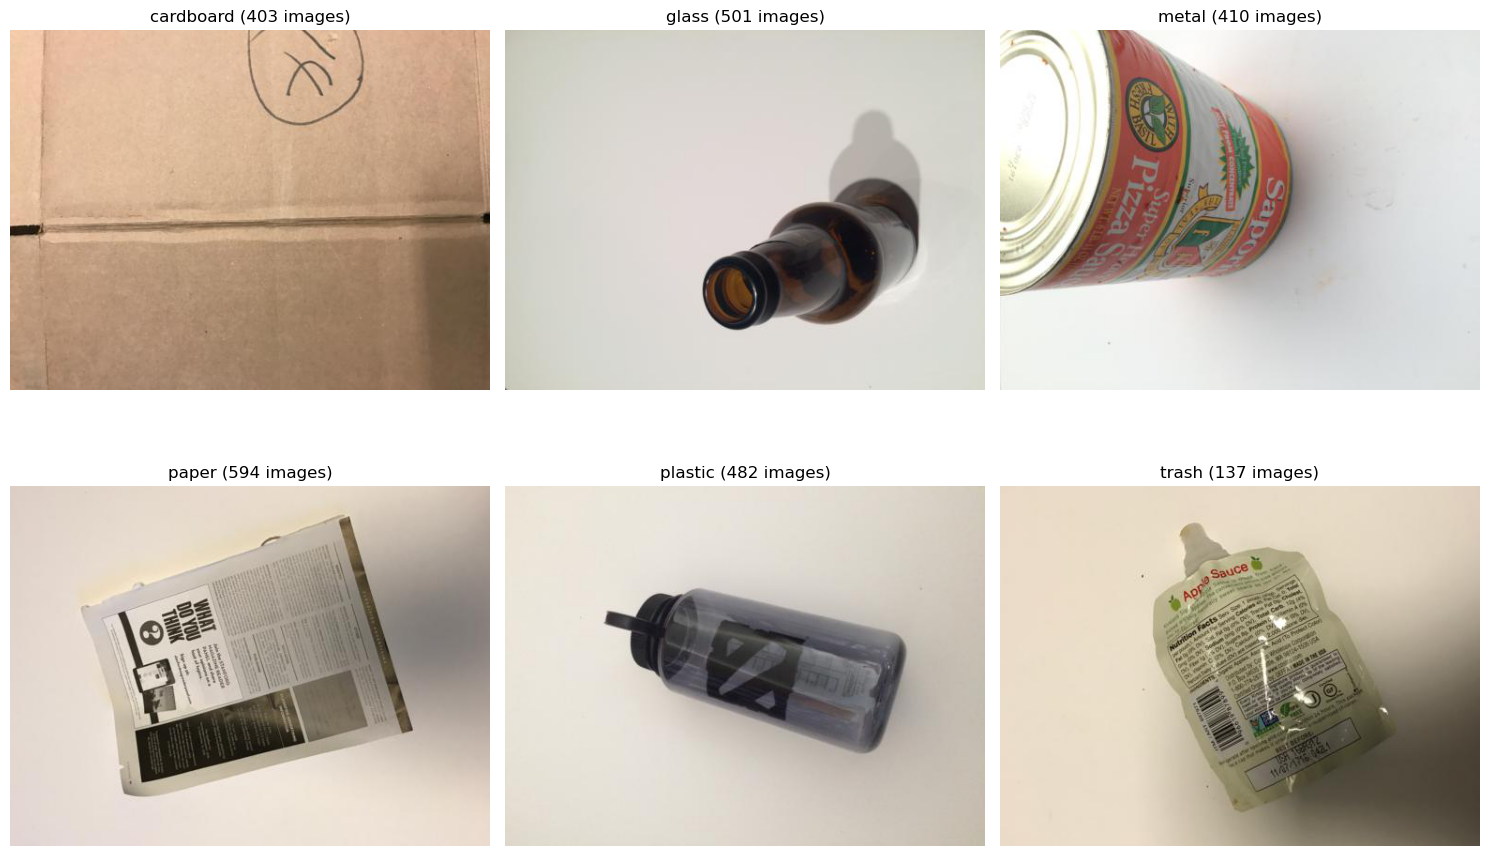

In [3]:
# Unzip the dataset
dataset_path = "dataset-resized.zip"
unzip_path = "dataset-resized"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

# List the contents of the unzipped folder
dataset_contents = os.listdir(unzip_path)

# List the contents of the "dataset-resized" folder
dataset_inner_contents = os.listdir(os.path.join(unzip_path, "dataset-resized"))

# Initialize a dictionary to store the number of images for each category
image_counts = {}
sample_images = {}

# Iterate over each category and count the number of images
for category in dataset_inner_contents:
    category_path = os.path.join(unzip_path, "dataset-resized", category)
    images_in_category = os.listdir(category_path)
    
    # Store the number of images in the category
    image_counts[category] = len(images_in_category)
    
    # Store a sample image path for each category
    sample_images[category] = os.path.join(category_path, images_in_category[0])

# Display the number of images in each category and a sample image
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, (category, image_path) in enumerate(sample_images.items()):
    img = mpimg.imread(image_path)
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].axis('off')
    axs[i//3, i%3].set_title(f"{category} ({image_counts[category]} images)")

plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
import shutil

# Create directories for training, validation, and test sets
train_dir = os.path.join(unzip_path, "train")
val_dir = os.path.join(unzip_path, "val")
test_dir = os.path.join(unzip_path, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Initialize split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Split the data and move the files to the respective directories
for category in dataset_inner_contents:
    category_path = os.path.join(unzip_path, "dataset-resized", category)
    images_in_category = os.listdir(category_path)
    
    # Split the images
    train_images, temp_images = train_test_split(images_in_category, test_size=1-train_ratio, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=test_ratio/(test_ratio+val_ratio), random_state=42)
    
    # Create category directories in train, val, and test directories
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    
    # Move the images to the respective directories
    for image in train_images:
        shutil.move(os.path.join(category_path, image), os.path.join(train_dir, category, image))
    for image in val_images:
        shutil.move(os.path.join(category_path, image), os.path.join(val_dir, category, image))
    for image in test_images:
        shutil.move(os.path.join(category_path, image), os.path.join(test_dir, category, image))

# Check the number of images in train, val, and test directories for each category
train_counts = {category: len(os.listdir(os.path.join(train_dir, category))) for category in dataset_inner_contents}
val_counts = {category: len(os.listdir(os.path.join(val_dir, category))) for category in dataset_inner_contents}
test_counts = {category: len(os.listdir(os.path.join(test_dir, category))) for category in dataset_inner_contents}

train_counts, val_counts, test_counts

({'cardboard': 336,
  'glass': 400,
  'metal': 336,
  'paper': 475,
  'plastic': 385,
  'trash': 333},
 {'cardboard': 40,
  'glass': 50,
  'metal': 41,
  'paper': 59,
  'plastic': 48,
  'trash': 14},
 {'cardboard': 41,
  'glass': 51,
  'metal': 41,
  'paper': 60,
  'plastic': 49,
  'trash': 14})

In [5]:
# Define data augmentation transformations for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# No augmentation for validation and test sets, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define parameters
batch_size = 32
target_size = (150, 150)

train_path = r"dataset-resized\train"
test_path = r"dataset-resized\test"
val_path = r"dataset-resized\val"

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    val_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 2265 images belonging to 6 classes.
Found 256 images belonging to 6 classes.
Found 252 images belonging to 6 classes.


In [6]:
# Balancing the dataset using Data Augmentation

save_path = {
    'cardboard':r"dataset-resized\train/cardboard",
    'metal': r'dataset-resized\train/metal',
    'trash': r'dataset-resized\train/trash'
}

augmented_counts_explicit = {
    'cardboard': 14,
    'metal': 8,
    'trash': 227
}

In [7]:
for category, count in augmented_counts_explicit.items():
    images = [f for f in os.listdir(save_path[category]) if os.path.isfile(os.path.join(save_path[category], f))]
    for i in range(count):
        img_path = os.path.join(save_path[category], np.random.choice(images))
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = x.reshape((1,) + x.shape)
        for batch in train_datagen.flow(x, batch_size=1, save_to_dir=save_path[category], save_prefix='aug', save_format='jpeg'):
            break

In [8]:
## building the model 
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6))  # 6 classes
model.add(Activation('softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                   

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=2000 // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=800 // batch_size
)

Epoch 1/50


62/62 [==============================] - 34s 525ms/step - loss: 1.7784 - accuracy: 0.1897 - val_loss: 1.6622 - val_accuracy: 0.2812
Epoch 2/50
62/62 [==============================] - 22s 356ms/step - loss: 1.6432 - accuracy: 0.3060
Epoch 3/50
62/62 [==============================] - 20s 328ms/step - loss: 1.5279 - accuracy: 0.3571
Epoch 4/50
62/62 [==============================] - 21s 338ms/step - loss: 1.4424 - accuracy: 0.4138
Epoch 5/50
62/62 [==============================] - 28s 455ms/step - loss: 1.4421 - accuracy: 0.4173
Epoch 6/50
62/62 [==============================] - 49s 789ms/step - loss: 1.4032 - accuracy: 0.4431
Epoch 7/50
62/62 [==============================] - 47s 768ms/step - loss: 1.3455 - accuracy: 0.4643
Epoch 8/50
62/62 [==============================] - 50s 811ms/step - loss: 1.3170 - accuracy: 0.4927
Epoch 9/50
62/62 [==============================] - 51s 825ms/step - loss: 1.2991 - accuracy: 0.5169
Epoch 10/50
62/62 [============================

In [12]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

8/8 [==============================] - 8s 1s/step - loss: 0.8664 - accuracy: 0.6389
Test Loss: 0.8663578629493713
Test Accuracy: 0.6388888955116272


loss: 0.8447:

This is the value of the loss function (which you specified when compiling the model, in this case, categorical_crossentropy) calculated over the entire test dataset. The loss function quantifies how well the predictions of the model align with the true labels in the test set. A lower loss indicates that the model's predictions are closer to the true labels.
accuracy: 0.7063:

This is the accuracy metric, which represents the proportion of correct predictions out of all predictions. An accuracy of 0.7063 (or 70.63%) means that the model correctly predicted the label for about 70.63% of the test images.
Test Loss: 0.8446604609489441:

This is just a reiteration of the loss value, presented in a more detailed format. The model's predictions resulted in this loss value when compared to the true labels of the test dataset.
Test Accuracy: 0.7063491940498352:

Again, a more detailed version of the accuracy metric. The model correctly classified approximately 70.63% of the images in the test dataset.
In summary, after training, you evaluated your model on a set of images it had never seen before (the test set). The model achieved an accuracy of about 70.63%, meaning it correctly predicted the category for roughly 70.63% of those test images. The loss value provides another measure of the model's performance, with lower values indicating better performance.

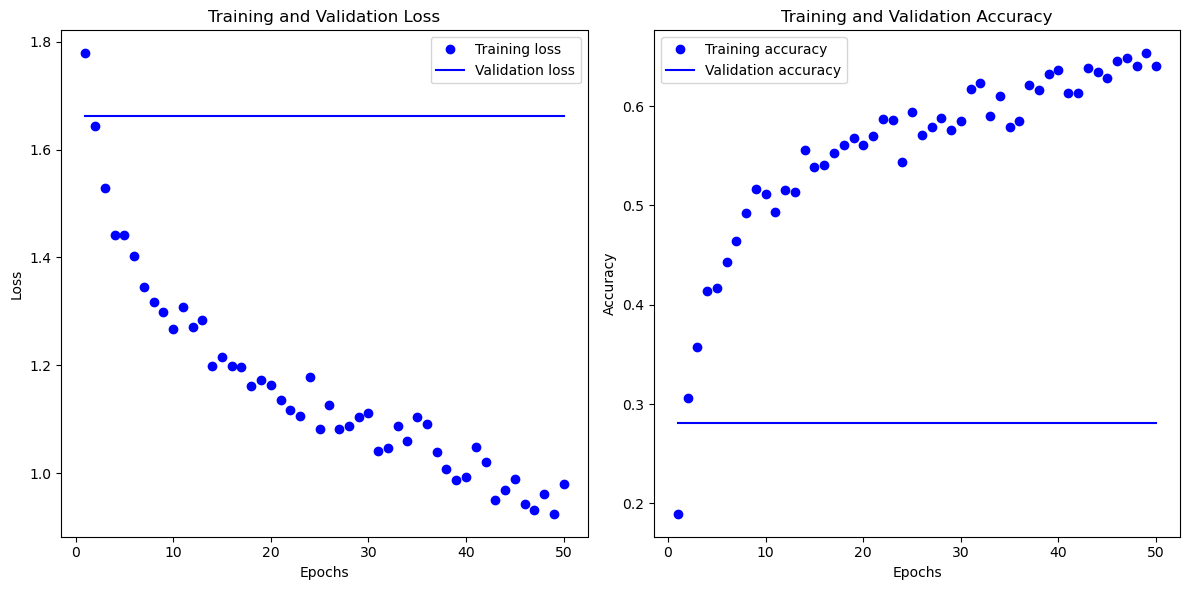

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training and validation metrics from the training history.
    """
    
    # Extract loss and accuracy values
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)
    
     # Check for mismatch in validation data length
    if len(val_loss) != len(train_loss):
        val_loss = [val_loss[0]] * len(train_loss)
        val_acc = [val_acc[0]] * len(train_acc)
    

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_training_history(history)

In [14]:
def preprocess_image(image_path, target_size=(150, 150)):
    """
    Load, resize, and preprocess the image for prediction.
    """
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    
    # Load and resize the image
    img = load_img(image_path, target_size=target_size)
    
    # Convert the image to an array and normalize
    img_array = img_to_array(img) / 255.0
    
    # Expand the dimensions to represent a batch of size 1
    img_batch = np.expand_dims(img_array, axis=0)
    
    return img_batch

def predict_image(image_path, model):
    """
    Predict the class of a single image.
    """
    # Preprocess the image
    img_batch = preprocess_image(image_path)
    
    # Make predictions
    predictions = model.predict(img_batch)
    
    # Get the class with highest probability
    predicted_class = np.argmax(predictions)
    
    # Convert class index to class label
    class_labels = train_generator.class_indices  # Assuming train_generator is in scope
    label_map = {v: k for k, v in class_labels.items()}
    
    return label_map[predicted_class]

In [15]:
# Example usage:
image_path = r"dataset-resized\test\cardboard\cardboard9.jpg"
predicted_label = predict_image(image_path, model)
print(f"The predicted class for the image is: {predicted_label}")

1/1 [==============================] - 1s 743ms/step
The predicted class for the image is: cardboard


In [16]:
image_path = r"dataset-resized\test\glass\glass161.jpg"
predicted_label = predict_image(image_path, model)
print(f"The predicted class for the image is: {predicted_label}")

1/1 [==============================] - 0s 116ms/step
The predicted class for the image is: glass
